# Load the results from lasso regression and run linear regression

### Load the output from the lasso regression and all features¶

- load the outputs from the Run_LasoRegression_and_Average.ipynb (obtain average coefficient weights for each feature).

- load all the features (output from DataExplorationAndPreProcessing.ipynb, AddingEmployeeSalary.ipynb, and AddingResponseStandardDeviation.ipyn

### Run linear regression 1000 times (with interaction terms)

- Chose the top 3 features from the lasso regression (based on the weight of the coefficient) and use those features plus the interactions among them.

- Run linear regression 1000 times and average the results.

### Save the output data (as .pkl file) for using them in the Streamlit app.

- Save the combined features and the results from the linear regression.

In [2]:
#Import packages

import numpy as np
import pandas as pd
import os


import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
color = sb.color_palette()
import matplotlib as mpl

%matplotlib inline

import pickle

from sklearn import preprocessing as pp 
#import the entire linear model
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr 
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

from scipy.stats import wilcoxon

### load features and outputs from the lasso regression

In [3]:
#Load features and turnover rate
feature_set = pd.read_pickle("./feature_set.pkl")
turnOverRate = pd.read_pickle("./turnOverRate.pkl")
location_pay = pd.read_pickle("./location_pay.pkl")
location_sd = pd.read_pickle("./location_sdS_df.pkl")

In [4]:
#Load the results from lasso regression.
with open('lasso_output.pickle', 'rb') as f:  
    test_r_squared, lasso_alpha, lasso_coef = pickle.load(f)

### Calculate the average coefficients for each feature in the lasso regression model and plot them

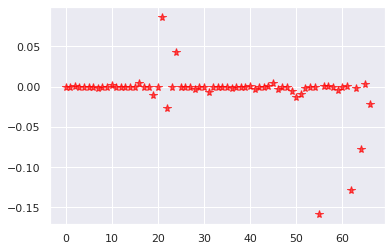

In [7]:
#Show the average weight of the coefficiencts.
lasso_coef_df = pd.DataFrame(data=lasso_coef)
mean_coef=lasso_coef_df.mean()

plt.plot(mean_coef,alpha=0.7,linestyle='none',marker='*',markersize=8,color='red') 

### Show a list of coefficients with large average weight (absolute weight)

In [8]:
abs_mean_coef=abs(mean_coef)
top_coef=abs_mean_coef.sort_values(ascending=False)
top_coef.head()

55    0.158653
62    0.128890
21    0.086848
64    0.077530
24    0.043275
dtype: float64

### Select the top 3 features and get their interaction terms

In [9]:
#Choose top 3 features.

#all features.
all_features = pd.concat([feature_set,location_pay,location_sd], axis = 1)

features_number = 3
#get the top n features and construct a new feature.
top_coef=abs_mean_coef.sort_values(ascending=False)

selected_features = all_features.iloc[:,top_coef.index[0]]

for features in range(features_number-1):
    selected_features = pd.concat([selected_features, all_features.iloc[:,top_coef.index[features+1]]], axis = 1)



In [10]:
#top 3 features with their interactions.
poly = pp.PolynomialFeatures(interaction_only=True,include_bias = False)
selected_features_interaction=poly.fit_transform(selected_features)
selected_features_interaction=pd.DataFrame(data=selected_features_interaction)
selected_features_interaction.head()

,0,1,2,3,4,5
0,0.467229,-1.180298,1.103600,-0.551469,0.515634,-1.302577
1,-1.504403,-1.045167,-0.092121,1.572352,0.138588,0.096282
2,0.888779,0.775737,-0.562840,0.689458,-0.500240,-0.436616
3,-0.026882,-0.108571,-0.092121,0.002919,0.002476,0.010002
4,0.679443,-0.224316,-1.280074,-0.152410,-0.869737,0.287141


In [11]:
#Order of features and interactions
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2']

### Run linear regression with interaction terms (1000 repeat)

In [12]:
#make a model with interactions.
#Run N times and take the average.
#Try to use the shuffle split function => later
x_linear = selected_features_interaction
y_linear = turnOverRate #Turn over

train_number = 1000
#Run this part for 1000 times and get the values for r-squared, alpha, and the weights.
#reg.alpha_, reg.coef_, r2score.

#initialize
linear_r_squared = np.zeros((train_number,1))
linear_coef = np.zeros((train_number,x_linear.shape[1]))

for trialNo in range(train_number):
    
    #split 80-20
    Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(x_linear, y_linear, test_size=0.2)
    

    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(Xl_train,Yl_train)
    
    
    Ypredl = linear_reg.predict(Xl_test)
    
    linear_r_squared[trialNo] = r2_score(Yl_test, Ypredl)
    linear_coef[trialNo,:] = linear_reg.coef_

### Check the distribution of the coefficient of determination (r-squared) and the average weights

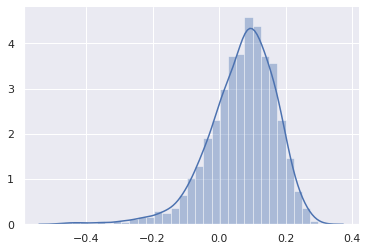

In [13]:
#Distribution of the coefficient of determination (r-squared)
linear_r_squared_df=pd.DataFrame(data=linear_r_squared)
#linear_r_squared_df.hist()
sb.distplot(linear_r_squared_df)
sb.despine()

In [14]:
#Check statistical significance
sum_ranks, pval_w = wilcoxon(linear_r_squared[:,0])
print(pval_w)

5.502226908981674e-80


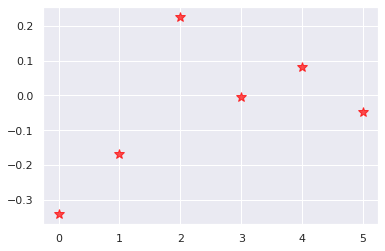

In [15]:
#Average weight of the coefficient for each feature (and interaction)
linear_coef_df = pd.DataFrame(data=linear_coef)

mean_linear_coef=linear_coef_df.mean()

plt.plot(mean_linear_coef,alpha=0.7,linestyle='none',marker='*',markersize=10,color='red') 


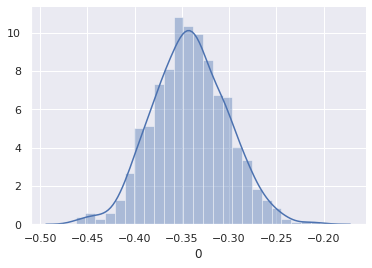

In [16]:
#Distribution of coefficients for the top feature (answer to the question "Do you think we provide excellent service")
sb.distplot(linear_coef_df.iloc[:,0])
sb.despine()

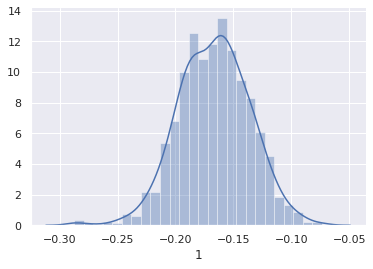

In [17]:
#Distribution of coefficients for the 2nd feature (Chef's tenure)
sb.distplot(linear_coef_df.iloc[:,1])
sb.despine()

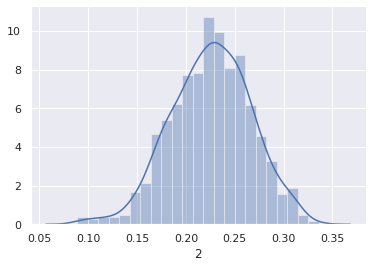

In [18]:
#Distribution of coefficients for the 3rd feature (answer to the question "Do managers avoid playing favorites")
sb.distplot(linear_coef_df.iloc[:,2])
sb.despine()

### Save the output and features (for use in the streamlit app)

In [19]:
with open('linear_output.pickle', 'wb') as f:
    pickle.dump([linear_r_squared_df, linear_coef_df], f)

In [20]:
#Features and interactions.
selected_features_interaction=pd.DataFrame(data=selected_features_interaction)
selected_features_interaction.to_pickle("./selected_features_interaction.pkl")


### Check partial correlations between the turnover rate and the top 3 features.

In [21]:
#From Fabian Pedregosa-Izquierdo, f@bianp.net
import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

turnOver_features = pd.concat([turnOverRate, selected_features], axis = 1)
partial_corr_array = turnOver_features.to_numpy()

# Calculate the partial correlation coefficients
partial_corr_results = partial_corr(partial_corr_array)

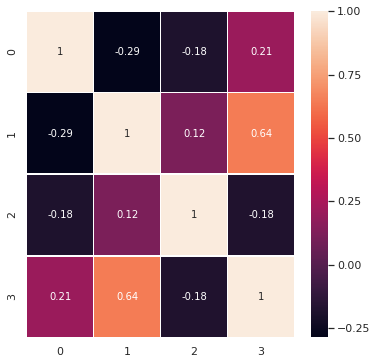

In [22]:
#Plot the matrix for partial correlation between the turnover rate (0 in the matrix) and top 3 features (1-3)

partial_corr_results_df = pd.DataFrame(data=partial_corr_results)
f, ax = plt.subplots(figsize=(6, 6))
sb.heatmap(partial_corr_results, annot=True, linewidths=.5, ax=ax)